In [1]:
#  Copyright (c) Microsoft Corporation.
#  Licensed under the MIT License.

# Introduction
Though users can automatically run the whole Quant research worklfow based on configurations with Qlib.

Some advanced users usally would like to carefully customize each component to explore more in Quant.

If you just want a simple example of Qlib. [Quick start](https://github.com/microsoft/qlib#quick-start) and [workflow_by_code](https://github.com/microsoft/qlib/blob/main/examples/workflow_by_code.ipynb) may be a better choice for you.

If you want to know more details about Quant research, this notebook may be a better place for you to start.

We hope this script could be a tutorial for users who are interested in the details of Quant.

This notebook tries to demonstrate how can we use Qlib to build components step by step. 

In [2]:
from pprint import pprint
from pathlib import Path
import pandas as pd

In [3]:
MARKET = "csi300"
BENCHMARK = "SH000300"
EXP_NAME = "tutorial_exp"

# Data

## Get data

Users can follow [the steps](https://github.com/microsoft/qlib/tree/main/scripts#download-qlib-data) to download data with CLI.

In this example we use the underlying API to automatically download data

In [4]:
import qlib
qlib.init()

[48767:MainThread](2023-01-19 10:02:32,399) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[48767:MainThread](2023-01-19 10:02:32,595) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[48767:MainThread](2023-01-19 10:02:32,596) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/jersonliao/.qlib/qlib_data/cn_data')}


## Inspect raw data

Currently, Qlib support several kinds of data source.

### Calendar

In [5]:
from qlib.data import D
D.calendar(start_time='2010-01-01', end_time='2017-12-31', freq='day')[:2]  # calendar data

array([Timestamp('2010-01-04 00:00:00'), Timestamp('2010-01-05 00:00:00')],
      dtype=object)

### Basic data

In [10]:
df = D.features(['SH601216'], ['$open', '$high', '$low', '$close', '$factor'], start_time='2022-11-01', end_time='2022-11-30')   

In [11]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index.get_level_values("datetime"),
                open=df['$open'],
                high=df['$high'],
                low=df['$low'],
                close=df['$close'])])
fig.show()

### price adjustment

Maybe you think the price is not what it looks like in real world.

Due to the price adjustment, the price will be different from the real trading data .

In [13]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index.get_level_values("datetime"),
                open=df['$open'] / df['$factor'],
                high=df['$high'] / df['$factor'],
                low=df['$low'] / df['$factor'],
                close=df['$close'] / df['$factor'])])
fig.show()

Please notice the price gap on [2020-05-26](http://vip.stock.finance.sina.com.cn/corp/view/vISSUE_ShareBonusDetail.php?stockid=601216&type=1&end_date=2020-05-20)

If we want to represent the change of assets value by price, adjust prices are necesary.
By default, Qlib stores the adjusted prices.

### Static universe V.S. dynamic universe

Dynamic universe

In [9]:
# dynamic universe
universe = D.list_instruments(D.instruments('csi100'),  start_time='2010-01-01', end_time='2020-12-31')
pprint(universe)

{'SH600000': [(Timestamp('2010-01-01 00:00:00'),
               Timestamp('2020-10-20 00:00:00'))],
 'SH600005': [(Timestamp('2010-01-01 00:00:00'),
               Timestamp('2013-12-13 00:00:00'))],
 'SH600009': [(Timestamp('2018-06-11 00:00:00'),
               Timestamp('2020-10-20 00:00:00')),
              (Timestamp('2010-01-01 00:00:00'),
               Timestamp('2011-06-30 00:00:00'))],
 'SH600010': [(Timestamp('2012-01-04 00:00:00'),
               Timestamp('2020-06-12 00:00:00')),
              (Timestamp('2010-01-01 00:00:00'),
               Timestamp('2010-06-30 00:00:00'))],
 'SH600011': [(Timestamp('2017-12-11 00:00:00'),
               Timestamp('2020-06-12 00:00:00')),
              (Timestamp('2012-07-02 00:00:00'),
               Timestamp('2016-12-09 00:00:00')),
              (Timestamp('2010-01-01 00:00:00'),
               Timestamp('2010-12-31 00:00:00'))],
 'SH600015': [(Timestamp('2010-01-01 00:00:00'),
               Timestamp('2020-10-20 00:00:00'))],
 'SH

In [10]:
print(len(universe))

202


Qlib use dynamic universe by default.

csi100 has around 100 stocks each day(it is not that accurate due to the low precision of data).

<AxesSubplot: xlabel='datetime'>

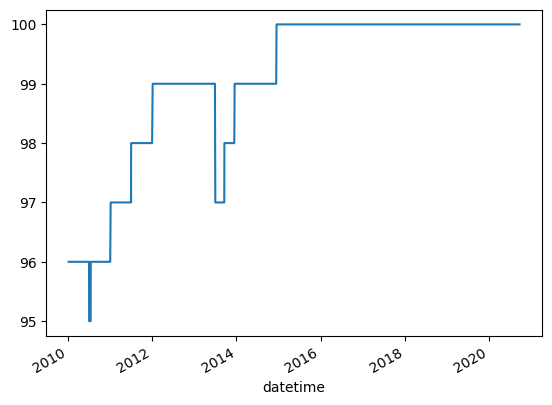

In [5]:
df = D.features(D.instruments('csi100'), ['$close'], start_time='2010-01-01', end_time='2020-12-31')   
df.groupby('datetime').size().plot()

### Point-In-Time data

#### download data
NOTE: To run the test faster, we only download the data of two stocks

In [ ]:
p = Path("~/.qlib/qlib_data/cn_data/financial").expanduser()

In [ ]:
if not p.exists():
    !cd ../../scripts/data_collector/pit/ && pip install -r requirements.txt
    !cd ../../scripts/data_collector/pit/ && python collector.py download_data --source_dir ~/.qlib/stock_data/source/pit --start 2000-01-01 --end 2020-01-01 --interval quarterly --symbol_regex "^(600519|000725).*"
    !cd ../../scripts/data_collector/pit/ && python collector.py normalize_data --interval quarterly --source_dir ~/.qlib/stock_data/source/pit --normalize_dir ~/.qlib/stock_data/source/pit_normalized
    !cd ../../scripts/ && python dump_pit.py dump --csv_path ~/.qlib/stock_data/source/pit_normalized --qlib_dir ~/.qlib/qlib_data/cn_data --interval quarterly
    pass

#### querying data
using `roewa(performanceExpressROEWa,业绩快报净资产收益率ROE-加权)` as an example

If we want to get fundamental data `in the most recent quarter` daily, we can use following example.

Maitai release part of its fundamental data on [2019-07-13](http://www.cninfo.com.cn/new/disclosure/detail?stockCode=600519&announcementId=1206443183&orgId=gssh0600519&announcementTime=2019-07-13) and  release others on [2019-07-18](http://www.cninfo.com.cn/new/disclosure/detail?stockCode=600519&announcementId=1206456129&orgId=gssh0600519&announcementTime=2019-07-18)

In [ ]:
instruments = ["sh600519"]
data = D.features(instruments, ['P($$roewa_q)'], start_time="2019-01-01", end_time="2019-07-19", freq="day")

In [ ]:
data.tail(15)

### experss engine


In [ ]:
D.features(["sh600519"], ['(EMA($close, 12) - EMA($close, 26))/$close - EMA((EMA($close, 12) - EMA($close, 26))/$close, 9)/$close'])


## Dataset loading and preprocessing 

Some heuristic principles of create features
- make the features comparable between instrumets: remove unit from the features.
- try to keep the distribution invariant
- keep the scale of features similar

### data loader

It's interface can be found [here](https://github.com/microsoft/qlib/blob/main/qlib/data/dataset/loader.py#L24) 

QlibDataLoader is an implementation which load data from Qlib's data source

In [12]:
from qlib.data.dataset.loader import QlibDataLoader

In [13]:
qdl = QlibDataLoader(config=(['$close / Ref($close, 10)'], ['RET10']))

In [14]:
qdl.load(instruments=['sh600519'], start_time='20190101', end_time='20191231')

,,RET10
datetime,instrument,
2019-01-02,sh600519,1.014326
2019-01-03,sh600519,0.998409
2019-01-04,sh600519,1.041883
2019-01-07,sh600519,1.053943
2019-01-08,sh600519,1.065878
...,...,...
2019-12-25,sh600519,0.978188
2019-12-26,sh600519,0.998329
2019-12-27,sh600519,1.000000


### data handler

finance data can't be perfect.

We have to process them before feeding them into Models

In [15]:
df = qdl.load(instruments=['sh600519'], start_time='20190101', end_time='20191231')

In [16]:
df.isna().sum()

RET10    4
dtype: int64

<AxesSubplot: ylabel='Frequency'>

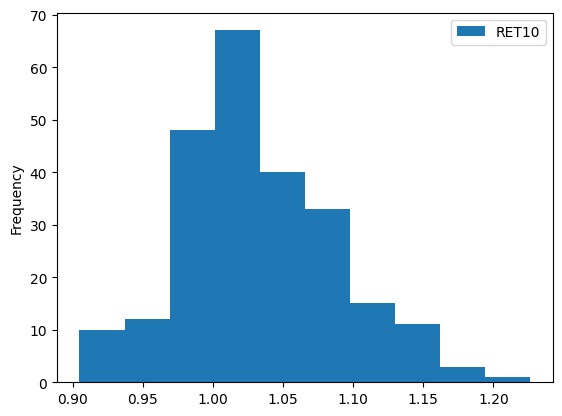

In [17]:
df.plot(kind='hist')

Datahander is responsible for data preprocessing and provides data fetching interface 



In [19]:
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import ZScoreNorm, Fillna

In [20]:
# NOTE: normally, the training & validation time range will be  `fit_start_time` ， `fit_end_time`
# however，all the components are decomposed, so the training & validation time range is unknown when preprocessing.
dh = DataHandlerLP(instruments=['sh600519'], start_time='20170101', end_time='20191231',
             infer_processors=[ZScoreNorm(fit_start_time='20170101', fit_end_time='20181231'), Fillna()],
             data_loader=qdl)

[76355:MainThread](2023-01-06 15:53:22,334) INFO - qlib.timer - [log.py:128] - Time cost: 0.004s | Loading data Done
[76355:MainThread](2023-01-06 15:53:22,339) INFO - qlib.timer - [log.py:128] - Time cost: 0.004s | ZScoreNorm Done
[76355:MainThread](2023-01-06 15:53:22,340) INFO - qlib.timer - [log.py:128] - Time cost: 0.000s | Fillna Done
[76355:MainThread](2023-01-06 15:53:22,340) INFO - qlib.timer - [log.py:128] - Time cost: 0.005s | fit & process data Done
[76355:MainThread](2023-01-06 15:53:22,341) INFO - qlib.timer - [log.py:128] - Time cost: 0.011s | Init data Done


In [21]:
df = dh.fetch()

In [ ]:
df

In [22]:
df.isna().sum()

RET10    0
dtype: int64

In [ ]:
df.plot(kind='hist')

### dataset

#### basic dataset

In [23]:
from qlib.data.dataset import DatasetH, TSDatasetH

In [24]:
ds = DatasetH(dh, segments={"train": ('20180101', '20181231'), "valid": ('20190101', '20191231')})

In [25]:
ds.prepare('train')

,,RET10
datetime,instrument,
2018-01-02,sh600519,0.745535
2018-01-03,sh600519,1.022683
2018-01-04,sh600519,1.075765
2018-01-05,sh600519,1.195880
2018-01-08,sh600519,1.514492
...,...,...
2018-12-24,sh600519,-0.529233
2018-12-25,sh600519,-0.764602
2018-12-26,sh600519,-1.105943


In [26]:
ds.prepare('valid')

,,RET10
datetime,instrument,
2019-01-02,sh600519,-0.001186
2019-01-03,sh600519,-0.278425
2019-01-04,sh600519,0.478799
2019-01-07,sh600519,0.688852
2019-01-08,sh600519,0.896746
...,...,...
2019-12-25,sh600519,-0.630645
2019-12-26,sh600519,-0.279825
2019-12-27,sh600519,-0.250719


#### Time Series Dataset

For different model, the required dataset format will be different.

For example, Qlib provides a Time Series Dataset(TSDatasetH) to help users to create time-series dataset.

In [27]:
ds = TSDatasetH(step_len=10, handler=dh, segments={"train": ('20180101', '20181231'), "valid": ('20190101', '20191231')})
train_sampler = ds.prepare('train')

/Users/jersonliao/qlib/qlib/data/dataset/__init__.py:389: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
train_sampler

In [35]:
train_sampler[0] # Retrieving the first example

array([[ 0.68848056],
       [ 1.4185905 ],
       [ 1.5865699 ],
       [ 1.294261  ],
       [ 0.7427344 ],
       [ 0.537918  ],
       [-0.3557673 ],
       [ 1.1682972 ],
       [ 0.9135168 ],
       [ 0.74553543]], dtype=float32)

In [ ]:
train_sampler['2018-01-08', 'sh600519']  # get the time series by <'timestamp', 'instrument_id'> index

### Off-the-shelf dataset

Qlib integrated some dataset alreadly

In [ ]:
handler_kwargs = {
        "start_time": "2008-01-01",
        "end_time": "2020-08-01",
        "fit_start_time": "2008-01-01",
        "fit_end_time": "2014-12-31",
        "instruments": MARKET,
}
handler_conf = {
    "class": "Alpha158",
    "module_path": "qlib.contrib.data.handler",
    "kwargs": handler_kwargs,
}
pprint(handler_conf)

In [ ]:
from qlib.utils import init_instance_by_config

In [ ]:
hd = init_instance_by_config(handler_conf)

Using config to create instance is a highly frequently used practice in Qlib (e.g. the [workflows configurations](https://github.com/microsoft/qlib/blob/main/examples/benchmarks/LightGBM/workflow_config_lightgbm_Alpha158.yaml) are based on it).


The above configuration is the same as the code below

In [ ]:
from qlib.contrib.data.handler import Alpha158
hd = Alpha158(**handler_kwargs)

This dataset has the same structure as the simple one with 1 column  we created just now.

In [ ]:
df = hd.fetch()

In [ ]:
df

In [ ]:
hd.data_loader

In [ ]:
hd.data_loader.fields

#### some details

The training data may not be the same as the test data.

e.g.
- the training dataset and test dataset use a different fitlering rules,  data processing

In [ ]:
hd.learn_processors

In [ ]:
hd.infer_processors

In [ ]:
hd.process_type # appending type

In [ ]:
hd.fetch(col_set="label", data_key=hd.DK_L)

In [ ]:
hd.fetch(col_set="label", data_key=hd.DK_I)

In [ ]:
dataset_conf = {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": hd,
            "segments": {
                "train": ("2008-01-01", "2014-12-31"),
                "valid": ("2015-01-01", "2016-12-31"),
                "test": ("2017-01-01", "2020-08-01"),
            },
        },
}

In [ ]:
dataset = init_instance_by_config(dataset_conf)

# Model Training & Inference

[Model interface](https://github.com/microsoft/qlib/blob/main/qlib/model/base.py)

In [ ]:
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord, SigAnaRecord

In [ ]:
model = init_instance_by_config({
        "class": "LGBModel",
        "module_path": "qlib.contrib.model.gbdt",
        "kwargs": {
            "loss": "mse",
            "colsample_bytree": 0.8879,
            "learning_rate": 0.0421,
            "subsample": 0.8789,
            "lambda_l1": 205.6999,
            "lambda_l2": 580.9768,
            "max_depth": 8,
            "num_leaves": 210,
            "num_threads": 20,
        },
})

In [ ]:
# start exp to train model
with R.start(experiment_name=EXP_NAME):
    model.fit(dataset)
    R.save_objects(trained_model=model)

    rec = R.get_recorder()
    rid = rec.id # save the record id

    # Inference and saving signal
    sr = SignalRecord(model, dataset, rec)
    sr.generate()

# Evaluation:
- Signal-based
- Portfolio-based: backtest 

In [ ]:
###################################
# prediction, backtest & analysis
###################################
port_analysis_config = {
    "executor": {
        "class": "SimulatorExecutor",
        "module_path": "qlib.backtest.executor",
        "kwargs": {
            "time_per_step": "day",
            "generate_portfolio_metrics": True,
        },
    },
    "strategy": {
        "class": "TopkDropoutStrategy",
        "module_path": "qlib.contrib.strategy.signal_strategy",
        "kwargs": {
            "signal": "<PRED>",
            "topk": 50,
            "n_drop": 5,
        },
    },
    "backtest": {
        "start_time": "2017-01-01",
        "end_time": "2020-08-01",
        "account": 100000000,
        "benchmark": BENCHMARK,
        "exchange_kwargs": {
            "freq": "day",
            "limit_threshold": 0.095,
            "deal_price": "close",
            "open_cost": 0.0005,
            "close_cost": 0.0015,
            "min_cost": 5,
        },
    },
}

# backtest and analysis
with R.start(experiment_name=EXP_NAME, recorder_id=rid, resume=True):

    # signal-based analysis
    rec = R.get_recorder()
    sar = SigAnaRecord(rec)
    sar.generate()
    
    #  portfolio-based analysis: backtest
    par = PortAnaRecord(rec, port_analysis_config, "day")
    par.generate()

# Loading results & Analysis

## loading data
Because Qlib leverage MLflow to save model & data.
All the data can be access by `mlflow ui`

In [ ]:
# load recorder
recorder = R.get_recorder(recorder_id=rid, experiment_name=EXP_NAME)

In [ ]:
# load previous results
pred_df = recorder.load_object("pred.pkl")
report_normal_df = recorder.load_object("portfolio_analysis/report_normal_1day.pkl")
positions = recorder.load_object("portfolio_analysis/positions_normal_1day.pkl")
analysis_df = recorder.load_object("portfolio_analysis/port_analysis_1day.pkl")

In [ ]:
# Previous Model can be loaded. but it is not used.
loaded_model = recorder.load_object("trained_model")
loaded_model

In [ ]:
from qlib.contrib.report import analysis_model, analysis_position

## analysis position

### report

In [ ]:
analysis_position.report_graph(report_normal_df)

### risk analysis

In [ ]:
analysis_position.risk_analysis_graph(analysis_df, report_normal_df)

## analysis model

In [ ]:
label_df = dataset.prepare("test", col_set="label")
label_df.columns = ['label']

### score IC

In [ ]:
pred_label = pd.concat([label_df, pred_df], axis=1, sort=True).reindex(label_df.index)
analysis_position.score_ic_graph(pred_label)

### model performance

In [ ]:
analysis_model.model_performance_graph(pred_label)